In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
random_state = 228

In [2]:
df = pd.read_csv("./data/france_weather_energy.csv")
df.head()

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,production_wind,production_solar
0,17.31,13.83,1021,80,1.42,20,99,4763.0,0.0
1,16.65,13.00,1021,79,0.67,35,77,4653.0,0.0
2,15.85,12.22,1020,79,1.25,350,24,4456.0,0.0
3,15.05,12.19,1020,83,1.61,358,1,4268.0,0.0
4,13.95,11.82,1020,87,1.44,349,5,3790.0,15.0


In [3]:
df.shape

(25771, 9)

In [4]:
df = df.sample(100, random_state=random_state)
df.shape

(100, 9)

In [5]:
y_cols = ["production_wind", "production_solar"]
X_ = df.drop(columns=y_cols)
y = df[y_cols]
display(X_.head())
display(y.head())

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all
22298,1.98,0.36,1037,89,4.00,42,96
19591,20.22,14.80,1016,71,1.01,339,25
13975,8.50,4.33,1020,75,4.18,211,100
9926,26.01,19.41,1012,67,3.56,249,100
22025,0.15,-0.11,1029,98,2.98,352,100


,production_wind,production_solar
22298,6425.0,0.0
19591,1879.0,3234.0
13975,8854.0,1992.0
9926,2850.0,2029.0
22025,1289.0,1.0


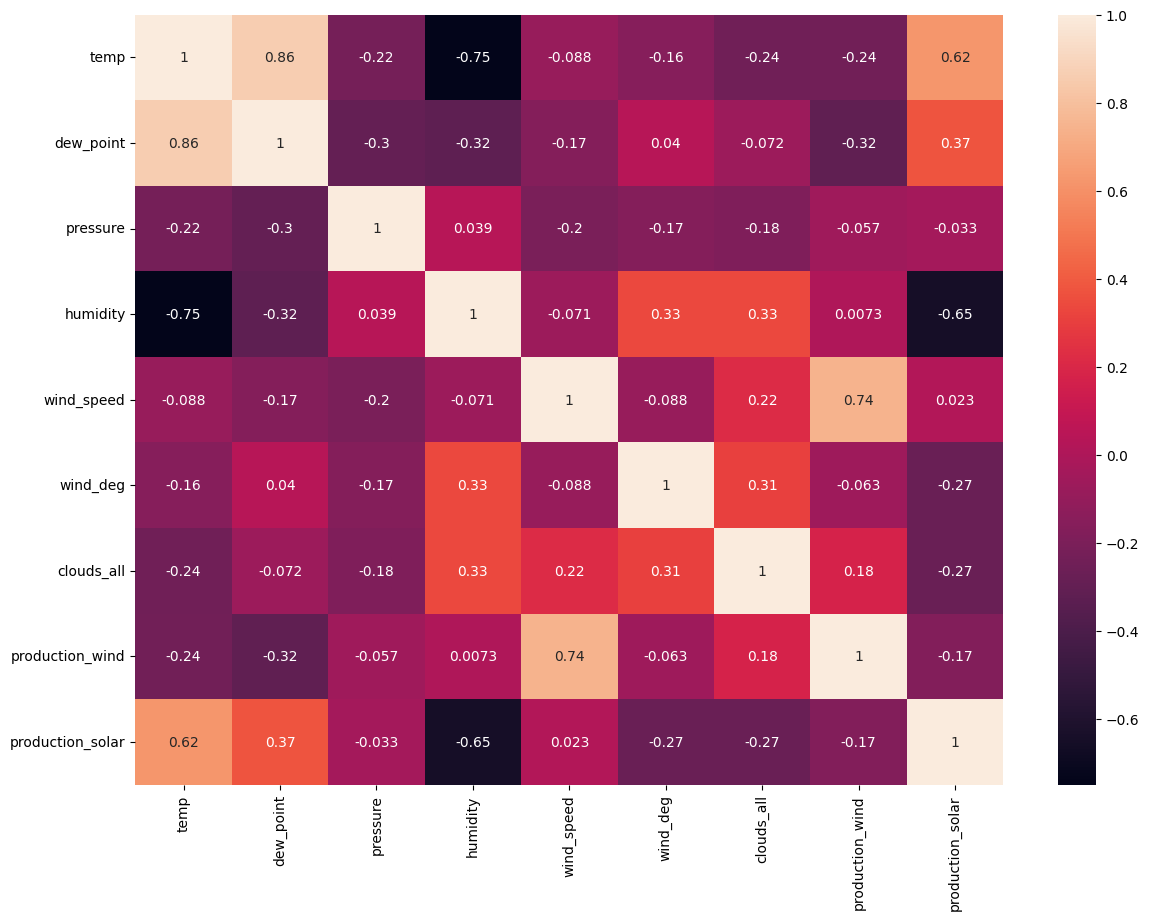

In [6]:
corr = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [7]:
significant_cols = corr[y_cols].abs().gt(0.1)
significant_cols.drop(index=y_cols, inplace=True)
display(significant_cols)

,production_wind,production_solar
temp,True,True
dew_point,True,True
pressure,False,False
humidity,False,True
wind_speed,True,False
wind_deg,False,True
clouds_all,True,True


In [8]:
wind_significant_cols = list(k for k, v in significant_cols["production_wind"].items() if v==True)
solar_significant_cols = list(k for k, v in significant_cols["production_solar"].items() if v==True)

print("Wind significant columns:", wind_significant_cols)
print("Solar significant columns:", solar_significant_cols)

Wind significant columns: ['temp', 'dew_point', 'wind_speed', 'clouds_all']
Solar significant columns: ['temp', 'dew_point', 'humidity', 'wind_deg', 'clouds_all']


In [9]:
standard_scalar = StandardScaler()
standard_scalar.fit(X_)
X = standard_scalar.transform(X_)
X = pd.DataFrame(X, columns=X_.columns)
X.head()

,temp,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all
0,-1.494270,-1.581771,2.687143,0.815202,0.543030,-1.499231,0.883336
1,0.765983,1.067203,-0.298571,-0.203093,-1.328192,1.461154,-0.862193
2,-0.686329,-0.853487,0.270136,0.023195,0.655679,0.185298,0.981675
3,1.483465,1.912893,-0.867279,-0.429381,0.267666,0.564068,0.981675
4,-1.721039,-1.667991,1.549728,1.324350,-0.095313,1.590734,0.981675


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [11]:
y_wind_train = y_train["production_wind"]
y_solar_train = y_train["production_solar"]
y_wind_test = y_test["production_wind"]
y_solar_test = y_test["production_solar"]

In [12]:
X_wind_train = X_train[wind_significant_cols]
X_solar_train = X_train[solar_significant_cols]
X_wind_test = X_test[wind_significant_cols]
X_solar_test = X_test[solar_significant_cols]

In [13]:
grid_params = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"]
}

In [14]:
grid_search_wind = GridSearchCV(SVR(), grid_params, refit=True, verbose=3, n_jobs=-1, cv=3)
grid_search_solar = GridSearchCV(SVR(), grid_params, refit=True, verbose=3, n_jobs=-1, cv=3)

In [15]:
grid_search_wind.fit(X_wind_train, y_wind_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=3)

In [16]:
grid_search_solar.fit(X_solar_train, y_solar_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=3)

In [17]:
y_wind_pred = grid_search_wind.predict(X_wind_test)
y_solar_pred = grid_search_solar.predict(X_solar_test)

In [18]:
print("Wind regression report:")
print(mean_squared_error(y_wind_test, y_wind_pred))

Wind regression report:
7934188.494534937


In [19]:
print("Solar regression report:")
print(mean_squared_error(y_solar_test, y_solar_pred))

Solar regression report:
1492362.2453168593


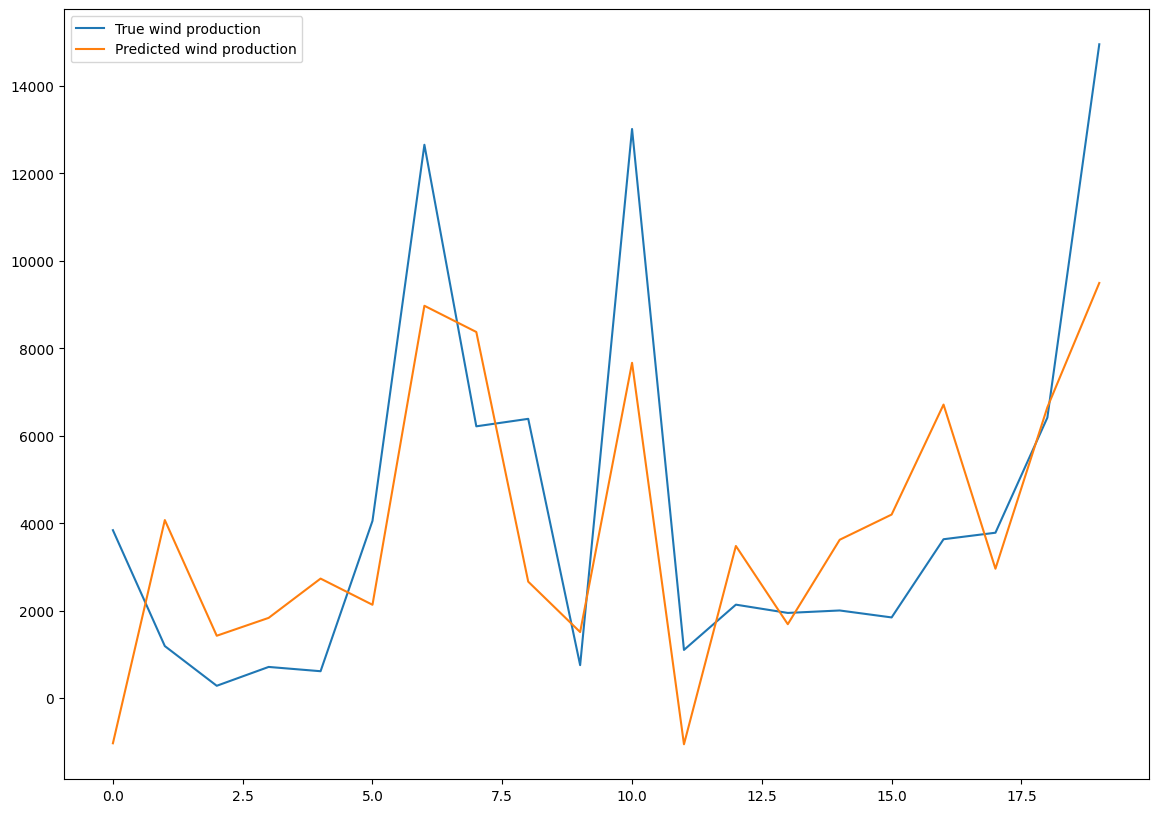

In [20]:
plt.figure(figsize=(14, 10))
plt.plot(y_wind_test.to_list(), label="True wind production")
plt.plot(y_wind_pred, label="Predicted wind production")
plt.legend()
plt.show()

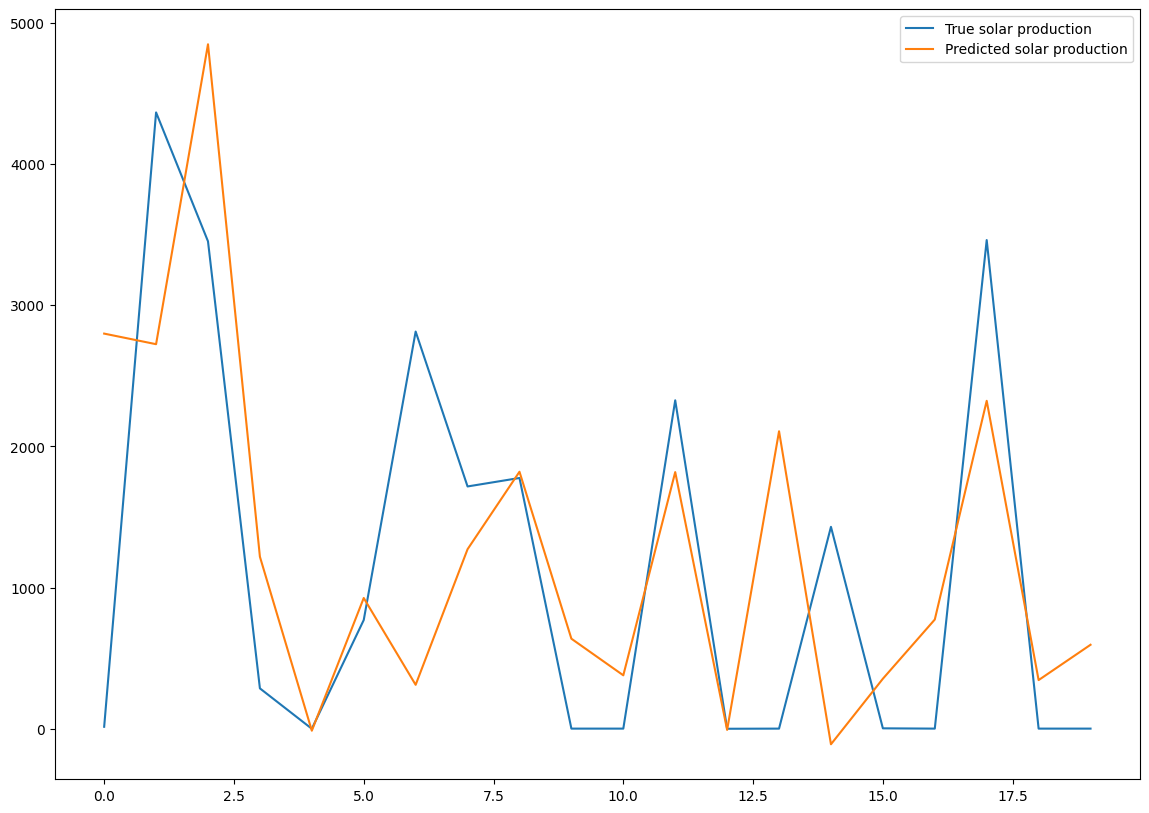

In [21]:
plt.figure(figsize=(14, 10))
plt.plot(y_solar_test.to_list(), label="True solar production")
plt.plot(y_solar_pred, label="Predicted solar production")
plt.legend()
plt.show()